In [1]:
#!/usr/bin/env python
# coding: utf-8

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#"""
#Created on Thu May 15 16:31:48 2025

In [3]:
import numpy as np
get_ipython().system('which python')
get_ipython().system('python --version')
print(np.__version__)

'which' is not recognized as an internal or external command,
operable program or batch file.


Python 3.13.3
2.2.5


In [4]:
import openeo
import geopandas as gpd
from openeo.processes import (and_, is_nan, is_valid, not_, is_nodata, or_, 
                              if_, array_create, lt, ProcessBuilder, run_udf, process)

In [6]:
from skimage.filters import threshold_otsu
import xarray as xr
import requests
from shapely.geometry import shape, MultiPolygon, mapping
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import json

In [7]:
import os
from dotenv import load_dotenv
load_dotenv()

False

In [8]:
# ==============================
# User Configuration Section
# ==============================

# credentials CDSE: add an .env file with your credentials 
# MY_USERNAME=mysecretuser
# MY_PASSWORD=mysecretpass

In [9]:
username = os.getenv("MY_USERNAME")
password = os.getenv("MY_PASSWORD")

openEO backend

In [10]:
backend = 'https://openeo.dataspace.copernicus.eu/'

out directory

In [11]:
outdir = "./results"
os.makedirs(outdir, exist_ok=True)

period to be downloaded

In [12]:
startdate = '2023-01-15'
enddate = '2023-01-16'

cloud probability 

In [13]:
cloud_prob = 100

resolution

In [14]:
res = 20.
    
    
# ==============================
# Authentication
# ==============================

In [15]:
eoconn = openeo.connect(backend, auto_validate=False)
eoconn.authenticate_oidc()
eoconn.describe_account()

Authenticated using refresh token.


{'info': {'oidc_userinfo': {'email': 'jhengblom@gmail.com',
   'email_verified': True,
   'family_name': 'Engblom',
   'given_name': 'Julia',
   'name': 'Julia Engblom',
   'preferred_username': 'jhengblom@gmail.com',
   'sub': 'd76a496b-6b23-4df1-b173-87f4f24d1c11'}},
 'name': 'Julia Engblom',
 'user_id': 'd76a496b-6b23-4df1-b173-87f4f24d1c11'}

In [16]:
geojson = eoconn.datacube_from_process("load_url", format = "GEOJSON", url = "https://gitlab.inf.unibz.it/Julia.Engblom/ice_snow/-/raw/main/andies_500.geojson?ref_type=heads")

In [17]:
# get S2 data
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
s2_bands = eoconn.load_collection(
    "SENTINEL2_L1C",
    bands = bands,
    temporal_extent=[startdate, enddate],
)

In [18]:
s2_bands = s2_bands.mask_polygon(mask=geojson)

In [19]:
s2_bands

In [20]:
# download to check if it worked. Takes quite long
# s2_bands.download(os.path.join(outdir, 's2_bands.nc'))

In [21]:
blue = s2_bands.band('B02')
green = s2_bands.band('B03')
red  = s2_bands.band('B04')
nir  = s2_bands.band('B08')
swir = s2_bands.band('B11')

Compute red/SWIR ratio (avoid division by zero)

In [22]:
red_swir = red / (swir + 1e-10)

NDSI

In [23]:
ndsi = (green - swir) / (green + swir)

In [24]:
# ndsi.download(os.path.join(outdir, 'ndsi.nc'))

NDVI

In [25]:
ndvi = (nir - red) / (nir + red)

In [26]:
# ndvi.download(os.path.join(outdir, 'ndvi.nc'))

Set a fixed NDSI threshold (candidate pixels) and a NDVI threshold to avoid vegetation

In [27]:
ndsi_threshold = 0.4
ndvi_threshold = 0.5

Build candidate mask: valid pixels with sufficient NDSI and low NDVI.

In [28]:
candidate_mask = (ndsi > ndsi_threshold) & (ndvi < ndvi_threshold)

In [29]:
candidate_mask

In [30]:
# the mask has the openEOs processing chunks around the aoi because of the nodata around the polygon
# changing the stretch to 0-1 shows the correct candidate mask

# result = candidate_mask.save_result(format='NetCDF')
# job = result.create_job()
# job.start_and_wait()
# job.download_results(target=outdir)


TO DOs<br>
    1. resample to 20 m spatial resolution<br>
    2. Compute dynamic red/SWIR threshold using Otsu's method on candidate pixels. among the candidates, where red/SWIR ratio is lower than dynamic threshold, classify those pixels as ice, as snow otherwise<br>



### TO DO 1. Resampling to 20 m

In [31]:
s2_bands_resampled = s2_bands.resample_spatial(resolution=20)

In [32]:
blue = s2_bands_resampled.band('B02')
green = s2_bands_resampled.band('B03')
red = s2_bands_resampled.band('B04')
nir  = s2_bands_resampled.band('B08')
swir = s2_bands_resampled.band('B11')

# Compute red/SWIR ratio (avoid division by zero)
red_swir = red / (swir + 1e-10)

# NDSI
ndsi = (green- swir) / (green + swir)

# NDVI
ndvi = (nir - red) / (nir + red)

# Build candidate mask: valid pixels with sufficient NDSI and low NDVI.
candidate_mask = (ndsi > ndsi_threshold) & (ndvi < ndvi_threshold) 

# candidate_mask.download(os.path.join(outdir, 'candidate_mask_resampled.nc'))


In [33]:
candidate_mask

### TO DO 2. Compute dynamic red/SWIR threshold using Otsu's method on candidate pixels. Among the candidates, where red/SWIR ratio is lower than dynamic threshold, classify those pixels as ice, as snow otherwise

In [34]:
# compute dynamic threshold over the red_swir, but only for pixels where candidate_mask is True

# first get red swir pixels in candidate mask

# candidate mask needs to be inversed so the red swir are computed to the masked area and not vice versa
inverse_mask = candidate_mask == 0
red_swir_candidates = red_swir.mask(inverse_mask)
# red_swir_candidates.download(os.path.join(outdir,'filtered_red_swir.nc'))

In [35]:
red_swir_candidates = red_swir_candidates.add_dimension(name="bands", label="red_swir", type="bands")

In [36]:
with open("otsu_udf.py") as f:
    udf_code = f.read()

In [37]:
def otsu_process(data, context=None):
    return process("run_udf", runtime="Python", version="3", data=data, udf=udf_code)


In [38]:
# This is a threshold per polygon

# classified = red_swir_candidates.apply_polygon(polygons=geojson, process=otsu_process)


In [39]:
# This is one global threshold

masked_candidates = red_swir_candidates.mask_polygon(geojson)
classified= masked_candidates.apply(otsu_process)


In [40]:
classified

In [41]:
classified.download(os.path.join(outdir, "classified.nc"))

In [43]:
ds = xr.open_dataset("results/classified.nc")
ds

<xarray.Dataset> Size: 372MB
Dimensions:   (t: 1, x: 6733, y: 13805)
Coordinates:
  * t         (t) datetime64[ns] 8B 2023-01-15
  * x         (x) float64 54kB 2.799e+05 2.8e+05 2.8e+05 ... 4.146e+05 4.146e+05
  * y         (y) float64 110kB 6.123e+06 6.123e+06 ... 5.847e+06 5.847e+06
Data variables:
    crs       |S1 1B ...
    red_swir  (t, y, x) float32 372MB ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

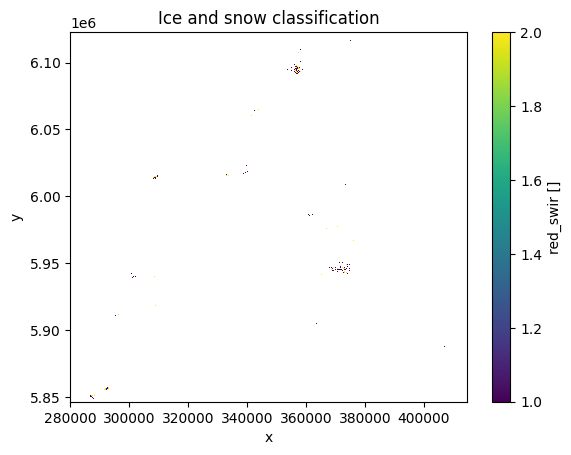

In [44]:
ds['red_swir'].plot(cmap='viridis')
plt.title("Ice and snow classification")
plt.xlabel("x")
plt.ylabel("y")
plt.show()